# Using Ragas to Evaluate a RAG Application built with LangChain and LangGraph

In the following notebook, we'll be looking at how [Ragas](https://github.com/explodinggradients/ragas) can be helpful in a number of ways when looking to evaluate your RAG applications!

While this example is rooted in LangChain/LangGraph - Ragas is framework agnostic (you don't even need to be using a framework!).

- 🤝 Breakout Room #1
  1. Task 1: Installing Required Libraries
  2. Task 2: Set Environment Variables
  3. Task 3: Synthetic Dataset Generation for Evaluation using Ragas
  4. Task 4: Evaluating our Pipeline with Ragas
  5. Task 6: Making Adjustments and Re-Evaluating

But first! Let's set some dependencies!

## Dependencies and API Keys:

> NOTE: Please skip the pip install commands if you are running the notebook locally.

We'll also need to provide our API keys.

First, OpenAI's for our LLM/embedding model combination!

In [1]:
from dotenv import load_dotenv

load_dotenv()

True

OPTIONALLY:

We can also provide a Ragas API key - which you can sign-up for [here](https://app.ragas.io/).

## Generating Synthetic Test Data

We wil be using Ragas to build out a set of synthetic test questions, references, and reference contexts. This is useful because it will allow us to find out how our system is performing.

> NOTE: Ragas is best suited for finding *directional* changes in your LLM-based systems. The absolute scores aren't comparable in a vacuum.

### Data Preparation

We'll prepare our data - and download our webpages which we'll be using for our data today.

These webpages are from [Simon Willison's](https://simonwillison.net/) yearly "AI learnings".

- [2023 Blog](https://simonwillison.net/2023/Dec/31/ai-in-2023/)
- [2024 Blog](https://simonwillison.net/2024/Dec/31/llms-in-2024/)

Let's start by collecting our data into a useful pile!

In [2]:
!mkdir data

mkdir: data: File exists


In [3]:
!curl https://simonwillison.net/2023/Dec/31/ai-in-2023/ -o data/2023_llms.html

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 31427    0 31427    0     0   182k      0 --:--:-- --:--:-- --:--:--  182k


In [4]:
!curl https://simonwillison.net/2024/Dec/31/llms-in-2024/ -o data/2024_llms.html

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 70286    0 70286    0     0   523k      0 --:--:-- --:--:-- --:--:--  527k


Next, let's load our data into a familiar LangChain format using the `DirectoryLoader`.

In [5]:
from langchain_community.document_loaders import DirectoryLoader

path = "data/"
loader = DirectoryLoader(path, glob="*.html")
docs = loader.load()

### Knowledge Graph Based Synthetic Generation

Ragas uses a knowledge graph based approach to create data. This is extremely useful as it allows us to create complex queries rather simply. The additional testset complexity allows us to evaluate larger problems more effectively, as systems tend to be very strong on simple evaluation tasks.

Let's start by defining our `generator_llm` (which will generate our questions, summaries, and more), and our `generator_embeddings` which will be useful in building our graph.

### Abstracted SDG

The above method is the full process - but we can shortcut that using the provided abstractions!

This will generate our knowledge graph under the hood, and will - from there - generate our personas and scenarios to construct our queries.



In [6]:
from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper
from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings
generator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4o"))
generator_embeddings = LangchainEmbeddingsWrapper(OpenAIEmbeddings())

In [7]:
from ragas.testset import TestsetGenerator

generator = TestsetGenerator(llm=generator_llm, embedding_model=generator_embeddings)
dataset = generator.generate_with_langchain_docs(docs, testset_size=10)

Applying HeadlinesExtractor:   0%|          | 0/2 [00:00<?, ?it/s]

Applying HeadlineSplitter:   0%|          | 0/2 [00:00<?, ?it/s]

Applying SummaryExtractor:   0%|          | 0/2 [00:00<?, ?it/s]

Applying CustomNodeFilter:   0%|          | 0/12 [00:00<?, ?it/s]

Applying [EmbeddingExtractor, ThemesExtractor, NERExtractor]:   0%|          | 0/26 [00:00<?, ?it/s]

Applying [CosineSimilarityBuilder, OverlapScoreBuilder]:   0%|          | 0/2 [00:00<?, ?it/s]

Generating personas:   0%|          | 0/2 [00:00<?, ?it/s]

Generating Scenarios:   0%|          | 0/3 [00:00<?, ?it/s]

Generating Samples:   0%|          | 0/12 [00:00<?, ?it/s]

In [8]:
dataset.to_pandas()

,user_input,reference_contexts,reference,synthesizer_name
0,what meta do with LLMs?,[Gullibility is the biggest unsolved problem C...,"In February, Meta released Llama, and later in...",single_hop_specifc_query_synthesizer
1,What recent legal action has the New York Time...,[that they haven’t shared yet. Vibes Based Dev...,The New York Times has launched a landmark law...,single_hop_specifc_query_synthesizer
2,What Simon Willison say about Weblog?,[Simon Willison’s Weblog Subscribe Stuff we fi...,Simon Willison’s Weblog includes a post titled...,single_hop_specifc_query_synthesizer
3,Wut iz Stanford Alpaca and how duz it relate t...,[issues in a way that’s surprisingly easy to f...,Stanford Alpaca is mentioned in the context of...,single_hop_specifc_query_synthesizer
4,How have advancements in prompt-driven app gen...,[<1-hop>\n\nPrompt driven app generation is a ...,Advancements in prompt-driven app generation a...,multi_hop_abstract_query_synthesizer
5,How are agents in AI being utilized for real-t...,[<1-hop>\n\nPrompt driven app generation is a ...,Agents in AI are being utilized for real-time ...,multi_hop_abstract_query_synthesizer
6,How has increased competition influenced the p...,[<1-hop>\n\nPrompt driven app generation is a ...,Increased competition among AI model providers...,multi_hop_abstract_query_synthesizer
7,How has the pricing of AI models evolved in 20...,[<1-hop>\n\nPrompt driven app generation is a ...,"In 2024, the pricing of AI models has signific...",multi_hop_abstract_query_synthesizer
8,How did the introduction of prompt-driven app ...,[<1-hop>\n\nyour camera feed with the model an...,"In 2024, the introduction of prompt-driven app...",multi_hop_specific_query_synthesizer
9,How have recent advancements in ChatGPT and ot...,[<1-hop>\n\nyour camera feed with the model an...,Recent advancements in ChatGPT and other large...,multi_hop_specific_query_synthesizer


#### OPTIONAL:

If you've provided your Ragas API key - you can use this web interface to look at the created data!

In [13]:
dataset.upload()

Testset uploaded! View at https://app.ragas.io/dashboard/alignment/testset/45d7742f-e0c6-4e85-9b66-6e819adfaec3


'https://app.ragas.io/dashboard/alignment/testset/45d7742f-e0c6-4e85-9b66-6e819adfaec3'

## LangChain RAG

Now we'll construct our LangChain RAG, which we will be evaluating using the above created test data!

### R - Retrieval

Let's start with building our retrieval pipeline, which will involve loading the same data we used to create our synthetic test set above.

> NOTE: We need to use the same data - as our test set is specifically designed for this data.

In [9]:
path = "data/"
loader = DirectoryLoader(path, glob="*.html")
docs = loader.load()

Now that we have our data loaded, let's split it into chunks!

In [10]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
split_documents = text_splitter.split_documents(docs)
len(split_documents)

73

#### ❓ Question: 

What is the purpose of the `chunk_overlap` parameter in the `RecursiveCharacterTextSplitter`?

Next up, we'll need to provide an embedding model that we can use to construct our vector store.

In [11]:
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

Now we can build our in memory QDrant vector store.

In [12]:
from langchain_qdrant import QdrantVectorStore
from qdrant_client import QdrantClient
from qdrant_client.http.models import Distance, VectorParams

client = QdrantClient(":memory:")

client.create_collection(
    collection_name="ai_across_years",
    vectors_config=VectorParams(size=1536, distance=Distance.COSINE),
)

vector_store = QdrantVectorStore(
    client=client,
    collection_name="ai_across_years",
    embedding=embeddings,
)

We can now add our documents to our vector store.

In [13]:
_ = vector_store.add_documents(documents=split_documents)

Let's define our retriever.

In [14]:
retriever = vector_store.as_retriever(search_kwargs={"k": 5})

Now we can produce a node for retrieval!

In [15]:
def retrieve(state):
  retrieved_docs = retriever.invoke(state["question"])
  return {"context" : retrieved_docs}

### Augmented

Let's create a simple RAG prompt!

In [16]:
from langchain.prompts import ChatPromptTemplate

RAG_PROMPT = """\
You are a helpful assistant who answers questions based on provided context. You must only use the provided context, and cannot use your own knowledge.

### Question
{question}

### Context
{context}
"""

rag_prompt = ChatPromptTemplate.from_template(RAG_PROMPT)

### Generation

We'll also need an LLM to generate responses - we'll use `gpt-4o-mini` to avoid using the same model as our judge model.

In [17]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini")

Then we can create a `generate` node!

In [18]:
def generate(state):
  docs_content = "\n\n".join(doc.page_content for doc in state["context"])
  messages = rag_prompt.format_messages(question=state["question"], context=docs_content)
  response = llm.invoke(messages)
  return {"response" : response.content}

### Building RAG Graph with LangGraph

Let's create some state for our LangGraph RAG graph!

In [19]:
from langgraph.graph import START, StateGraph
from typing_extensions import List, TypedDict
from langchain_core.documents import Document

class State(TypedDict):
  question: str
  context: List[Document]
  response: str

Now we can build our simple graph!

> NOTE: We're using `add_sequence` since we will always move from retrieval to generation. This is essentially building a chain in LangGraph.

In [20]:
graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

Let's do a test to make sure it's doing what we'd expect.

In [21]:
response = graph.invoke({"question" : "How are LLM agents useful?"})

In [22]:
response["response"]

'LLM agents are useful in several ways, primarily highlighting their abilities to act on behalf of individuals as digital assistants and to leverage tools for problem-solving. Here are the key points regarding their utility:\n\n1. **Autonomy and Action**: Some LLM agents are designed to act autonomously, similar to a travel agent, executing tasks and making decisions based on user input. This suggests they can alleviate the burden of decision-making in various domains.\n\n2. **Programming and Code Execution**: Despite their tendency to hallucinate or produce incorrect outputs, LLMs can generate code, test its validity, and self-correct through iterative processes—this makes them particularly effective in coding scenarios. The ability to integrate tools like a Code Interpreter allows LLMs to refine their outputs based on real-time testing and execution results.\n\n3. **Ease of Development**: LLMs are not as complex to build as one might expect. With just a few hundred lines of Python an

## Evaluating the App with Ragas

Now we can finally do our evaluation!

We'll start by running the queries we generated usign SDG above through our application to get context and responses.

In [23]:
for test_row in dataset:
  response = graph.invoke({"question" : test_row.eval_sample.user_input})
  test_row.eval_sample.response = response["response"]
  test_row.eval_sample.retrieved_contexts = [context.page_content for context in response["context"]]

In [24]:
dataset.to_pandas()

,user_input,retrieved_contexts,reference_contexts,response,reference,synthesizer_name
0,what meta do with LLMs?,[So training an LLM still isn’t something a ho...,[Gullibility is the biggest unsolved problem C...,"Meta has developed LLMs, such as Llama, which ...","In February, Meta released Llama, and later in...",single_hop_specifc_query_synthesizer
1,What recent legal action has the New York Time...,"[Since then, almost every major LLM (and most ...",[that they haven’t shared yet. Vibes Based Dev...,The New York Times has recently launched a lan...,The New York Times has launched a landmark law...,single_hop_specifc_query_synthesizer
2,What Simon Willison say about Weblog?,[Simon Willison’s Weblog\n\nSubscribe\n\nStuff...,[Simon Willison’s Weblog Subscribe Stuff we fi...,Simon Willison's weblog provides insights and ...,Simon Willison’s Weblog includes a post titled...,single_hop_specifc_query_synthesizer
3,Wut iz Stanford Alpaca and how duz it relate t...,[So training an LLM still isn’t something a ho...,[issues in a way that’s surprisingly easy to f...,Stanford Alpaca is related to the acceleration...,Stanford Alpaca is mentioned in the context of...,single_hop_specifc_query_synthesizer
4,How have advancements in prompt-driven app gen...,[OpenAI are not the only game in town here. Go...,[<1-hop>\n\nPrompt driven app generation is a ...,"In 2024, advancements in prompt-driven app gen...",Advancements in prompt-driven app generation a...,multi_hop_abstract_query_synthesizer
5,How are agents in AI being utilized for real-t...,[OpenAI are not the only game in town here. Go...,[<1-hop>\n\nPrompt driven app generation is a ...,In the context of real-time camera feed analys...,Agents in AI are being utilized for real-time ...,multi_hop_abstract_query_synthesizer
6,How has increased competition influenced the p...,[This prompt-driven custom interface feature i...,[<1-hop>\n\nPrompt driven app generation is a ...,Increased competition among AI model providers...,Increased competition among AI model providers...,multi_hop_abstract_query_synthesizer
7,How has the pricing of AI models evolved in 20...,[This prompt-driven custom interface feature i...,[<1-hop>\n\nPrompt driven app generation is a ...,"In 2024, the pricing of AI models underwent si...","In 2024, the pricing of AI models has signific...",multi_hop_abstract_query_synthesizer
8,How did the introduction of prompt-driven app ...,[Prompt driven app generation is a commodity a...,[<1-hop>\n\nyour camera feed with the model an...,The introduction of prompt-driven app generati...,"In 2024, the introduction of prompt-driven app...",multi_hop_specific_query_synthesizer
9,How have recent advancements in ChatGPT and ot...,[How should we feel about this as software eng...,[<1-hop>\n\nyour camera feed with the model an...,Recent advancements in ChatGPT and other large...,Recent advancements in ChatGPT and other large...,multi_hop_specific_query_synthesizer


Then we can convert that table into a `EvaluationDataset` which will make the process of evaluation smoother.

In [25]:
from ragas import EvaluationDataset

evaluation_dataset = EvaluationDataset.from_pandas(dataset.to_pandas())

We'll need to select a judge model - in this case we're using the same model that was used to generate our Synthetic Data.

In [26]:
from ragas import evaluate
from ragas.llms import LangchainLLMWrapper

evaluator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4o-mini"))

Next up - we simply evaluate on our desired metrics!

In [27]:
from ragas.metrics import LLMContextRecall, Faithfulness, FactualCorrectness, ResponseRelevancy, ContextEntityRecall, NoiseSensitivity
from ragas import evaluate, RunConfig

custom_run_config = RunConfig(timeout=360)

result_1 = evaluate(
    dataset=evaluation_dataset,
    metrics=[LLMContextRecall(), Faithfulness(), FactualCorrectness(), ResponseRelevancy(), ContextEntityRecall(), NoiseSensitivity()],
    llm=evaluator_llm,
    run_config=custom_run_config
)
result_1

Evaluating:   0%|          | 0/72 [00:00<?, ?it/s]

{'context_recall': 0.6611, 'faithfulness': 0.9144, 'factual_correctness': 0.4750, 'answer_relevancy': 0.7616, 'context_entity_recall': 0.4642, 'noise_sensitivity_relevant': 0.2780}

## Making Adjustments and Re-Evaluating

Now that we've got our baseline - let's make a change and see how the model improves or doesn't improve!

> NOTE: This will be using Cohere's Rerank model (which was updated fairly [recently](https://docs.cohere.com/v2/changelog/rerank-v3.5)) - please be sure to [sign-up for an API key!](https://docs.cohere.com/reference/about)


We'll first set our retriever to return more documents, which will allow us to take advantage of the reranking.

In [28]:
retriever = vector_store.as_retriever(search_kwargs={"k": 20})

Reranking, or contextual compression, is a technique that uses a reranker to compress the retrieved documents into a smaller set of documents.

This is essentially a slower, more accurate form of semantic similarity that we use on a smaller subset of our documents.

In [29]:
from langchain.retrievers.contextual_compression import ContextualCompressionRetriever
from langchain_cohere import CohereRerank

def retrieve_adjusted(state):
  compressor = CohereRerank(model="rerank-v3.5")
  compression_retriever = ContextualCompressionRetriever(
    base_compressor=compressor, base_retriever=retriever, search_kwargs={"k": 5}
  )
  retrieved_docs = compression_retriever.invoke(state["question"])
  return {"context" : retrieved_docs}

We can simply rebuild our graph with the new retriever!

In [30]:
class State(TypedDict):
  question: str
  context: List[Document]
  response: str

graph_builder = StateGraph(State).add_sequence([retrieve_adjusted, generate])
graph_builder.add_edge(START, "retrieve_adjusted")
graph = graph_builder.compile()

In [31]:
response = graph.invoke({"question" : "How are LLM agents useful?"})
response["response"]

'LLM agents can be seen as useful primarily in the domain of writing code, where they demonstrate considerable capability. The context suggests that their effectiveness in generating code is notable due to the relatively simpler grammar rules of programming languages compared to natural languages. Moreover, LLM agents are often thought of in two ways: as agents that perform tasks on behalf of users (similar to travel agents) and as systems that can use tools iteratively to solve problems. \n\nHowever, there is skepticism regarding their broader utility, particularly because of concerns about their tendency to accept information without critically assessing its truthfulness, which poses a challenge for meaningful decision-making. The discussion raises doubts about whether LLM agents can fully realize their potential without overcoming this issue of "gullibility," implying that while they may exhibit significant utility in specific tasks like coding, their overall effectiveness as autono

In [32]:
import time

for test_row in dataset:
  response = graph.invoke({"question" : test_row.eval_sample.user_input})
  test_row.eval_sample.response = response["response"]
  test_row.eval_sample.retrieved_contexts = [context.page_content for context in response["context"]]

In [33]:
result_2 = evaluate(
    dataset=evaluation_dataset,
    metrics=[LLMContextRecall(), Faithfulness(), FactualCorrectness(), ResponseRelevancy(), ContextEntityRecall(), NoiseSensitivity()],
    llm=evaluator_llm,
    run_config=custom_run_config
)
result_2

Evaluating:   0%|          | 0/72 [00:00<?, ?it/s]

{'context_recall': 0.6611, 'faithfulness': 0.9026, 'factual_correctness': 0.4625, 'answer_relevancy': 0.7607, 'context_entity_recall': 0.4529, 'noise_sensitivity_relevant': 0.2048}

#### ❓ Question: 

Which system performed better, on what metrics, and why?

In [40]:
import numpy as np
import matplotlib.pyplot as plt


def normalize_eval_result(item) -> dict:
    return {k: round(v, 4) for k, v in item._repr_dict.items()}

def compare(
    x,
    y,
    x_name: str = "Model 1",
    y_name: str = "Model 2",
) -> None:
    dict1 = normalize_eval_result(x)
    dict2 = normalize_eval_result(y)

    assert dict1.keys() == dict2.keys()

    metrics = list(dict1.keys())
    values1 = list(dict1.values())
    values2 = list(dict2.values())

    x = np.arange(len(metrics))
    width = 0.35

    fig, ax = plt.subplots()
    ax.bar(x - width / 2, values1, width, label=x_name, color="blue", alpha=0.7)
    ax.bar(x + width / 2, values2, width, label=y_name, color="orange", alpha=0.7)

    ax.set_xlabel("Metrics")
    ax.set_ylabel("Values")
    ax.set_title("Comparison of Models")
    ax.set_xticks(x)
    ax.set_xticklabels(metrics)
    ax.legend()

    plt.ylim(0, 1)
    plt.show()

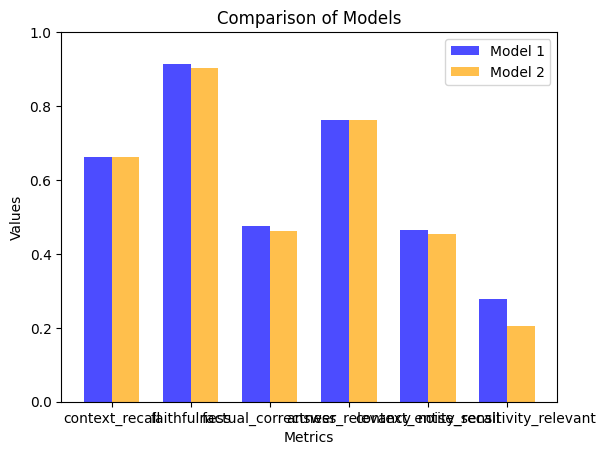

In [41]:
compare(result_1, result_2)